# (試圖)進行一些分析
不知道有沒有辦法寫出來欸哈哈  

讀我從 carta 圈的框框裡面的 pixel value (在 ratio map 上讀)  
計算平均之後，畫成類似趨勢圖的東西  

嗚嗚，但我不知道應該用哪張 ratio map 啦

## Prepare 之備料

### Import Modular

In [38]:
# modular

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS

from regions import Regions


### Universal para
記一些參數，我就是喜歡分段啊怎麼了

In [39]:
pixelStep = 0.1 # 參考上個程式的
commonPath = '/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/tinyBeam/3_ratio-map/' # 因為

### Read ratio maps
寄生了上一隻程式的菜單

In [40]:
# 從另一邊摳來的，反正就是建立 ratio map 的清單
requiree = [('HCO1-0_4.5',  'CO1-0_4.5'),   # 復古返場版
            ('HCO1-0_2.89',  'CO1-0_2.89'), # HOC+(1-0) 原生 beam 版
            
            # 都以 commonBeam 除以 CO(1-0) 組
            ('HCO2-1_1.65', 'CO1-0_1.65'),  
            ('HCO3-2_1.65', 'CO1-0_1.65'),
            ('HCO4-3_1.65', 'CO1-0_1.65'),

            ('HCO4-3_0.29', 'CO2-1_0.39'),  # high-J組-1

            ('HCO4-3_0.29', 'CO3-2_0.29'),  # high-J組-2

            ('CO3-2_0.29', 'CO1-0_1.64'),   # Satoki 的那篇 NGC1068
            ('CO3-2_1.65', 'CO1-0_1.65'),
            ]


ratioD = {} # 大字典那層
for nu, de in requiree:
    mapName = f'{nu}_over_{de}'
    hdul = fits.open(f"{commonPath}{mapName}_ratio_regrid{pixelStep}.fits")

    header = hdul[0].header
    image = hdul[0].data.squeeze()
    wcs = WCS(header, naxis=2)

    # 存入資料字典，這樣是雙層字典，方便以鍵取值
    ratioD[mapName] = {
        "hdul": hdul,
        "header": header,
        "ima": image,
        "wcs": wcs
    }

### Read .crtf file
ref:  
https://astropy-regions.readthedocs.io/en/stable/region_io.html  
或是更上層的文件

regions 庫有兩種主要類型的區域物件：

- PixelRegion： 直接使用像素座標來定義的區域（例如 x=100, y=200
- SkyRegion： 用 WCS（應該是赤經赤緯） 

In [41]:
boxesPath = f'{commonPath}arm-from-CO3-2_box_wcs.ctrf'
boxes = Regions.read(boxesPath, format='crtf')

box_name = []
for i, b in enumerate(boxes):  
    box_name.append(b.meta.get('label'))


## Weeeeee
這邊是用遮罩，總之就算是我學到新東西ㄅ

**to_mask() 只能用於 PixelRegion 物件**  
然後我記得我的 crtf 是存成 WCS 的  
所以需要用 to_pixel() 進行轉換，  
幸好讀 ratio map 的時候有順便讀 wcs infomation


**先簡單這樣寫**  
聽說 mask.cutout(ratio_ima) 回傳的東西不只一件...  
反正之後東西抽風了就從這裡先改


In [ ]:
for k in ratioD:
    ratio_avg = {} # 一次性放比值字典
    ratio_ima = ratioD[k]['ima'] # 先試一個
    ratio_wcs = ratioD[k]['wcs'] # WCS 資訊

    # 走過全部的區域
    for i, b in enumerate(boxes):
        boxName = b.meta.get('label') # 讀那個框框的 label
        pixelBox = b.to_pixel(ratio_wcs) # 轉成像素座標，才能用 to_mask
        mask = pixelBox.to_mask() # 將 pixelBox 之內標記為為 True，其餘為 False
        cutt = mask.cutout(ratio_ima) # 依照 mask 所述，裁剪圖片 (圖片：ratio_ima)
        theR = cutt # 這個是修改的接口哈哈屁眼

        if theR.size > 0: # 算像素值的平均
            ratio_avg[boxName] = np.nanmean(theR) # 使用 nanmean 可以忽略數據中的 NaN 值
        else:
            print(f"Warr: there is no any good pixel in the region {boxName}")
            ratio_avg[boxName] = np.nan
    '''
    print(f"{k} Ratio AVG")
    for boxName, avgg in ratio_avg.items():
        print(f"{boxName}: {avgg:.4f}")
    '''

'''
哈哈有點不知道這邊的東西應該怎麼取出呆畫圖，
全部寫在一個巢裡面感覺有點擠
'''

## Take off function
**需要在有 ratioD 的環境中使用**  
為了方便只對一個圖做測試，所以做了這個  
不用客氣  

輸入：那張 ratio map 的名字 (str)，也就是 ratioD 的鍵  
回傳：key = boxName, value = average-of-ratio 的一個字典

In [64]:
def Ratio_avg(theRatioMap):

    ratio_avg = {} # 一次性放比值字典
    ratio_ima = ratioD[theRatioMap]['ima'] # 先試一個
    ratio_wcs = ratioD[theRatioMap]['wcs'] # WCS 資訊

    for i, b in enumerate(boxes):
        boxName = b.meta.get('label') # 讀那個框框的 label
        pixelBox = b.to_pixel(ratio_wcs) # 轉成像素座標，才能用 to_mask
        mask = pixelBox.to_mask() # 將 pixelBox 之內標記為為 True，其餘為 False
        cutt = mask.cutout(ratio_ima) # 依照 mask 所述，裁剪圖片 (圖片：ratio_ima)
        theR = cutt # 這個是修改的接口哈哈屁眼

        
        if theR.size > 0: # 算像素值的平均
            ratio_avg[boxName] = np.nanmean(theR) # 使用 nanmean 可以忽略數據中的 NaN 值
        else:
            print(f"Warr: there is no any good pixel in the region {boxName}")
            ratio_avg[boxName] = np.nan

    return ratio_avg

## Plottttttt
非常之他媽激動  
雖然沒想好應該怎麼排的但是先路了勞資等下要組會

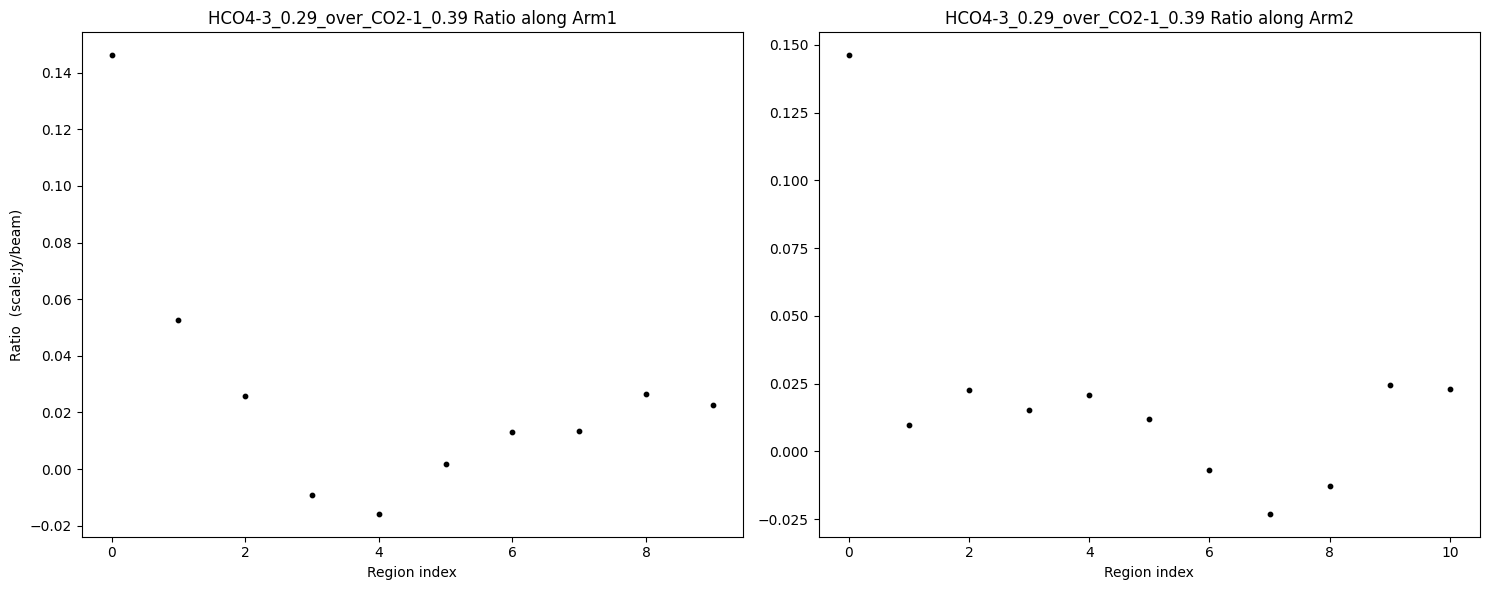

In [ ]:
# 單支，試個
aa = Ratio_avg('HCO4-3_0.29_over_CO2-1_0.39')
A1, A2 = [], [] # arm1, 2的數據嘻嘻你媽，非常不可靠的順序，隨便啦媽的我之後再想

for k, v in aa.items():
    if k == 'water disk':
        A1.append(v)
        A2.append(v)
    elif k[1] == '1':
        A1.append(v)
    elif k[1] == '2':
        A2.append(v)

fig, axx = plt.subplots(1, 2, figsize=(15, 6))
ratioName = 'HCO4-3_0.29_over_CO2-1_0.39'
# arm1
for i in range(len(A1)):
    axx[0].scatter(i, A1[i], c='k', s=10)
axx[0].set_title(f'{ratioName} Ratio along Arm1')
axx[0].set_xlabel('Region index')
axx[0].set_ylabel('Ratio  (scale:Jy/beam)')

#arm2
for i in range(len(A2)):
    axx[1].scatter(i, A2[i], c='k', s=10)
axx[1].set_title(f'{ratioName} Ratio along Arm2')
axx[1].set_xlabel('Region index')

plt.tight_layout()
plt.show()

'''
為什麼會他媽有負的啦
'''

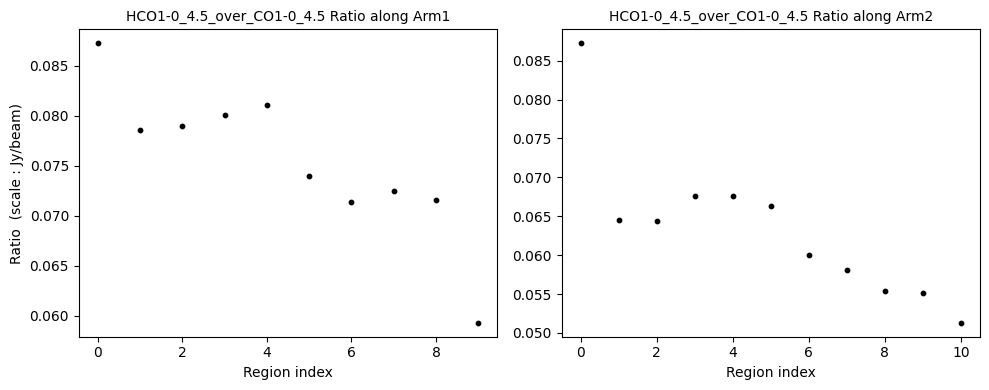

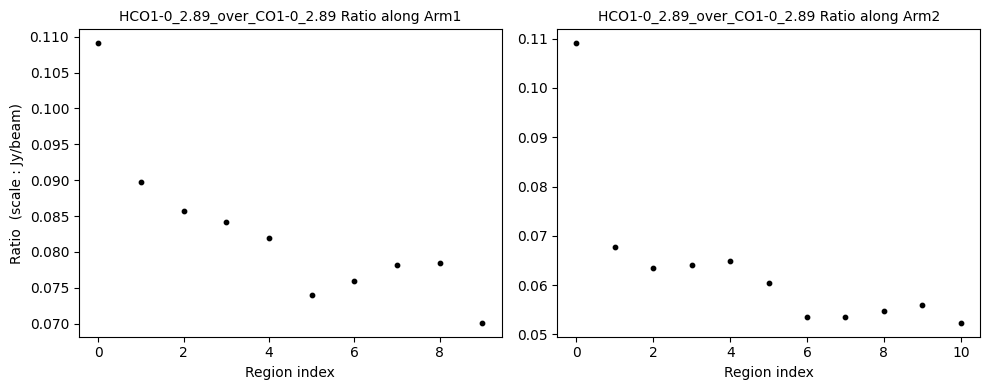

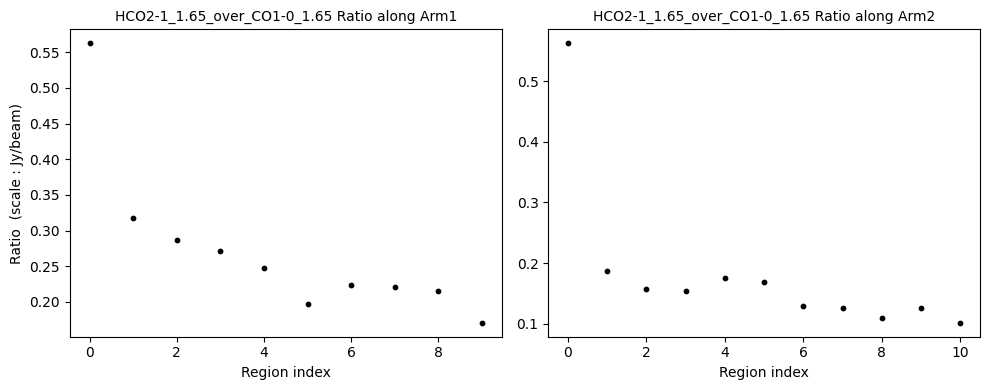

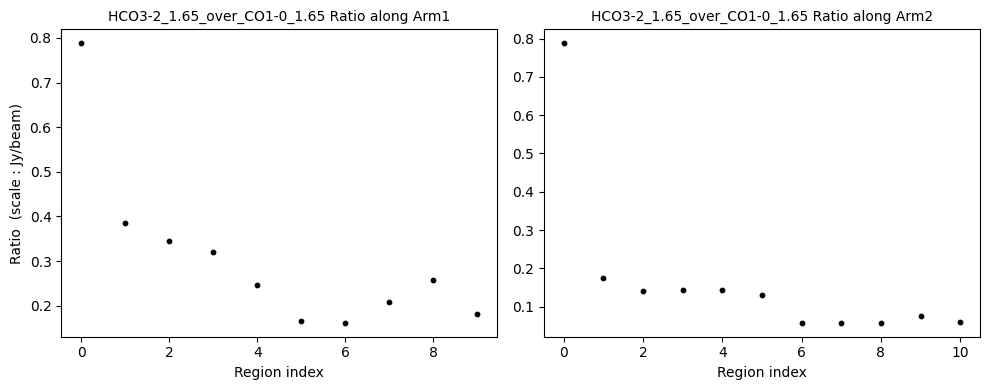

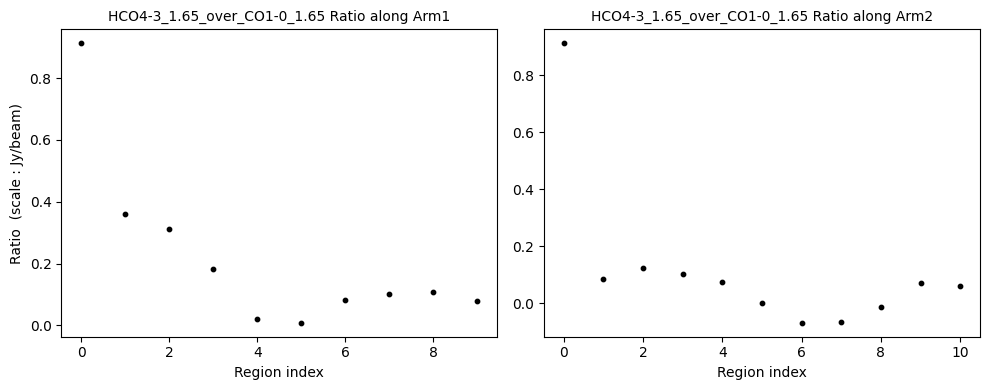

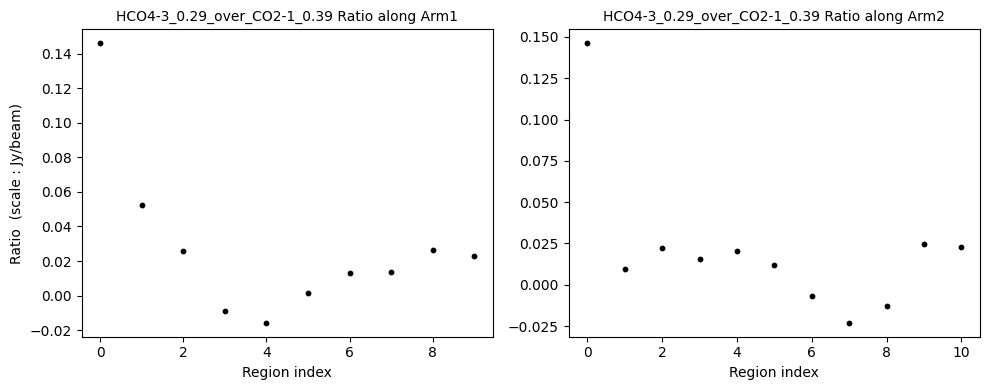

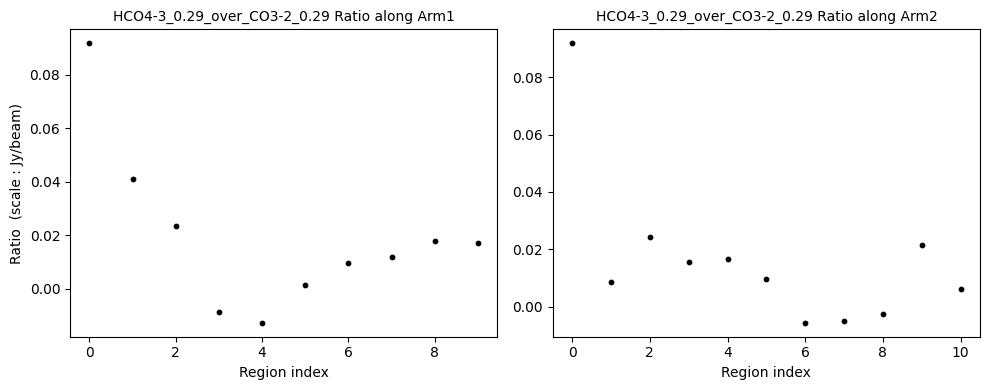

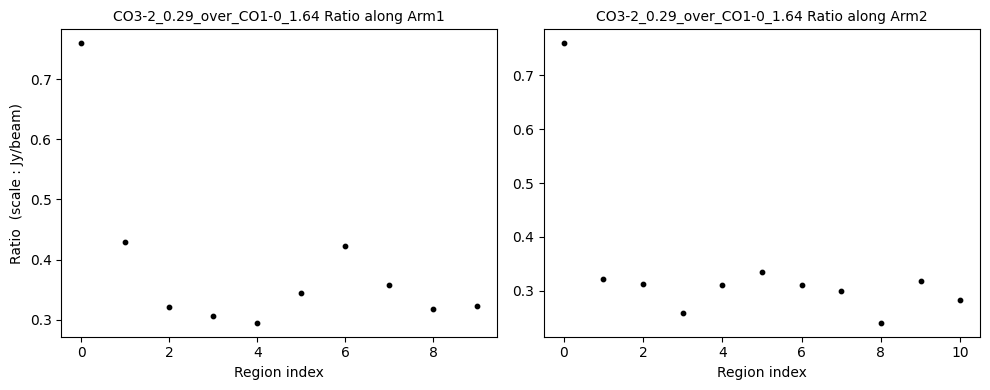

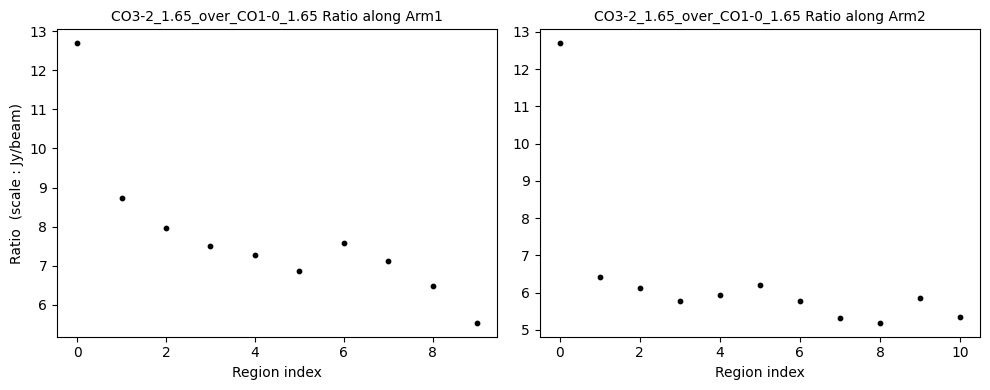

In [99]:
# 迴圈，試個
for ratioName in ratioD:
    ratio_avg = {} # 一次性放比值字典
    ratio_ima = ratioD[ratioName]['ima'] # 先試一個
    ratio_wcs = ratioD[ratioName]['wcs'] # WCS 資訊

    # 走過全部的區域
    for i, b in enumerate(boxes):
        boxName = b.meta.get('label') # 讀那個框框的 label
        pixelBox = b.to_pixel(ratio_wcs) # 轉成像素座標，才能用 to_mask
        mask = pixelBox.to_mask() # 將 pixelBox 之內標記為為 True，其餘為 False
        cutt = mask.cutout(ratio_ima) # 依照 mask 所述，裁剪圖片 (圖片：ratio_ima)
        theR = cutt # 這個是修改的接口哈哈屁眼

        if theR.size > 0: # 算像素值的平均
            ratio_avg[boxName] = np.nanmean(theR) # 使用 nanmean 可以忽略數據中的 NaN 值
        else:
            print(f"Warr: there is no any good pixel in the region {boxName}")
            ratio_avg[boxName] = np.nan
    

##################################################################################################


    A1, A2 = [], [] # arm1, 2的數據嘻嘻你媽，非常不可靠的順序，隨便啦媽的我之後再想

    for k, v in ratio_avg.items():
        if k == 'water disk':
            A1.append(v)
            A2.append(v)
        elif k[1] == '1':
            A1.append(v)
        elif k[1] == '2':
            A2.append(v)

    # plottt
    fig, axx = plt.subplots(1, 2, figsize=(10, 4))
    # arm1
    for i in range(len(A1)):
        axx[0].scatter(i, A1[i], c='k', s=10)
    axx[0].set_title(f'{ratioName} Ratio along Arm1', fontsize=10)
    axx[0].set_xlabel('Region index')
    axx[0].set_ylabel('Ratio  (scale : Jy/beam)')

    #arm2
    for i in range(len(A2)):
        axx[1].scatter(i, A2[i], c='k', s=10)
    axx[1].set_title(f'{ratioName} Ratio along Arm2', fontsize=10)
    axx[1].set_xlabel('Region index')

    plt.tight_layout()
    plt.show()
